In [1]:
%matplotlib inline
import librosa
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
import csv
import scipy
import itertools
import umap.umap_ as umap
from IPython.display import Audio, display, HTML
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler
from sklearn.manifold import TSNE
import umap.umap_ as umap
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

centroid_max  centroid_min  centroid_mean  centroid_std  rolloff_max  \
0   4031.364538   1027.079258    1784.416546    360.194166  7644.287109   
1   5444.293577    421.091729    1529.871314    613.197888  8085.717773   
2   4669.770713    417.254802    1552.637786    395.649207  6556.860352   
3   3236.442116    318.713500    1070.110059    429.542379  7611.987305   
4   4464.156642    849.658285    1835.507009    585.947299  7084.423828   

   rolloff_min  rolloff_mean  rolloff_std  contrast_max  contrast_min  ...  \
0  1830.322266   3806.418650   949.383832     48.289165      4.028252  ...   
1   333.764648   3548.986873  1725.338349     48.775996      5.534489  ...   
2   441.430664   3041.089944   884.842654     67.980056      4.558865  ...   
3   387.597656   2185.061787  1222.372310     53.952526      5.438508  ...   
4  1152.026367   3581.003346  1253.847208     54.526649      6.113804  ...   

   mfcc_19_max  mfcc_19_min  mfcc_19_mean  mfcc_19_std  mfcc_20_max  \
0    32.866340   -23.219631      1.219947     6.853878    19.209179   
1    27.740530   -17.131062      0.532144     6.769286    17.467901   
2    16.524359   -29.785425     -2.231391     5.534097    23.665482   
3    16.595015   -21.426252     -3.406940     5.655832    29.324226   
4     4.889854   -41.730530    -11.701833     7.430688    20.845287   

   mfcc_20_min  mfcc_20_mean  mfcc_20_std       tempo  genre  
0   -20.962769     -3.538389     6.161644  123.046875  blues  
1   -32.333900     -4.090439     6.538787  107.666016  blues  
2   -23.899199     -4.049148     6.599841  161.499023  blues  
3   -18.845253     -1.500599     5.899070  172.265625  blues  
4   -34.022064     -5.859701     8.214063  135.999178  blues  

[5 rows x 122 columns]

In [3]:
features = df.iloc[:, :-1]
X = StandardScaler().fit_transform(np.array(features, dtype = float))
y = LabelEncoder().fit_transform(df.iloc[:, -1])

In [4]:
def get_tsne_embeddings(features, n_components=2, perplexity=15, iteration=20000):
    tsne_embedding = TSNE(n_components=n_components,
                     perplexity=perplexity,
                     verbose=0,
                     n_iter=iteration).fit_transform(X)
    return MinMaxScaler().fit_transform(tsne_embedding)


def get_umap_embeddings(features, n_components=2, neighbor=15, distance=0.1):
    umap_embedding = umap.UMAP(n_neighbors=neighbor,
                               min_dist=distance,
                               n_epochs=5000,
                               metric='correlation', 
                               n_components=n_components, 
                               verbose=False).fit_transform(X)
    return MinMaxScaler().fit_transform(umap_embedding)

In [5]:
tsne_embeddings = dict()
perplexities = [10,15,20,25,30]
iterations = [5000,10000,15000,20000,25000]
for perplexity, iteration in tqdm(list(itertools.product(perplexities,iterations))): #for a prettier progress bar
    tsne_embedding = get_tsne_embeddings(features,
                                         perplexity=perplexity,
                                         iteration=iteration)
    tsne_embeddings[f"{perplexity}_{iteration}"]= tsne_embedding

  0%|          | 0/25 [00:00<?, ?it/s]

In [6]:
color_scheme = {
 'classical': '#FE88FC',
 'jazz': '#F246FE',
 'blues': '#BF1CFD', 
 'metal': '#6ECE58',
 'rock': '#35B779',
 'disco': '#1F9E89',
 'pop': '#Fb9B06',
 'reggae': '#ED6925',
 'hiphop': '#CF4446',   
 'country': '#000004',   
 }

def plot_components(embeddings, n_rows, n_cols, title, suptitle):
    """helper function to plot embeddings"""
    fig, ax = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(20,20))
    r=0
    c=0
    for i in embeddings:
        df_ = pd.DataFrame(embeddings[i])
        df_.columns = [f'pc{i}' for i in range(1, len(df_.columns)+1)]
        df_['genre'] = df.iloc[:,-1]
        genres = df_.genre.unique()
        if c>n_cols-1: c=0; r+=1
        if r> n_rows-1: break
        for genre in genres:
            ax[r,c].scatter(df_[df_.genre==genre]['pc1'],
                            df_[df_.genre==genre]['pc2'], 
                            color=color_scheme[genre],
                            s=1
                           )
        ax[r,c].set_title(title.format(i.split('_')[0],i.split('_')[1]))
        ax[r,c].axis('off')
        c+=1

    plt.figlegend(df_.genre.unique(), loc='center right', prop={'size': 18}, markerscale=10);
    plt.suptitle(suptitle,fontsize=24);

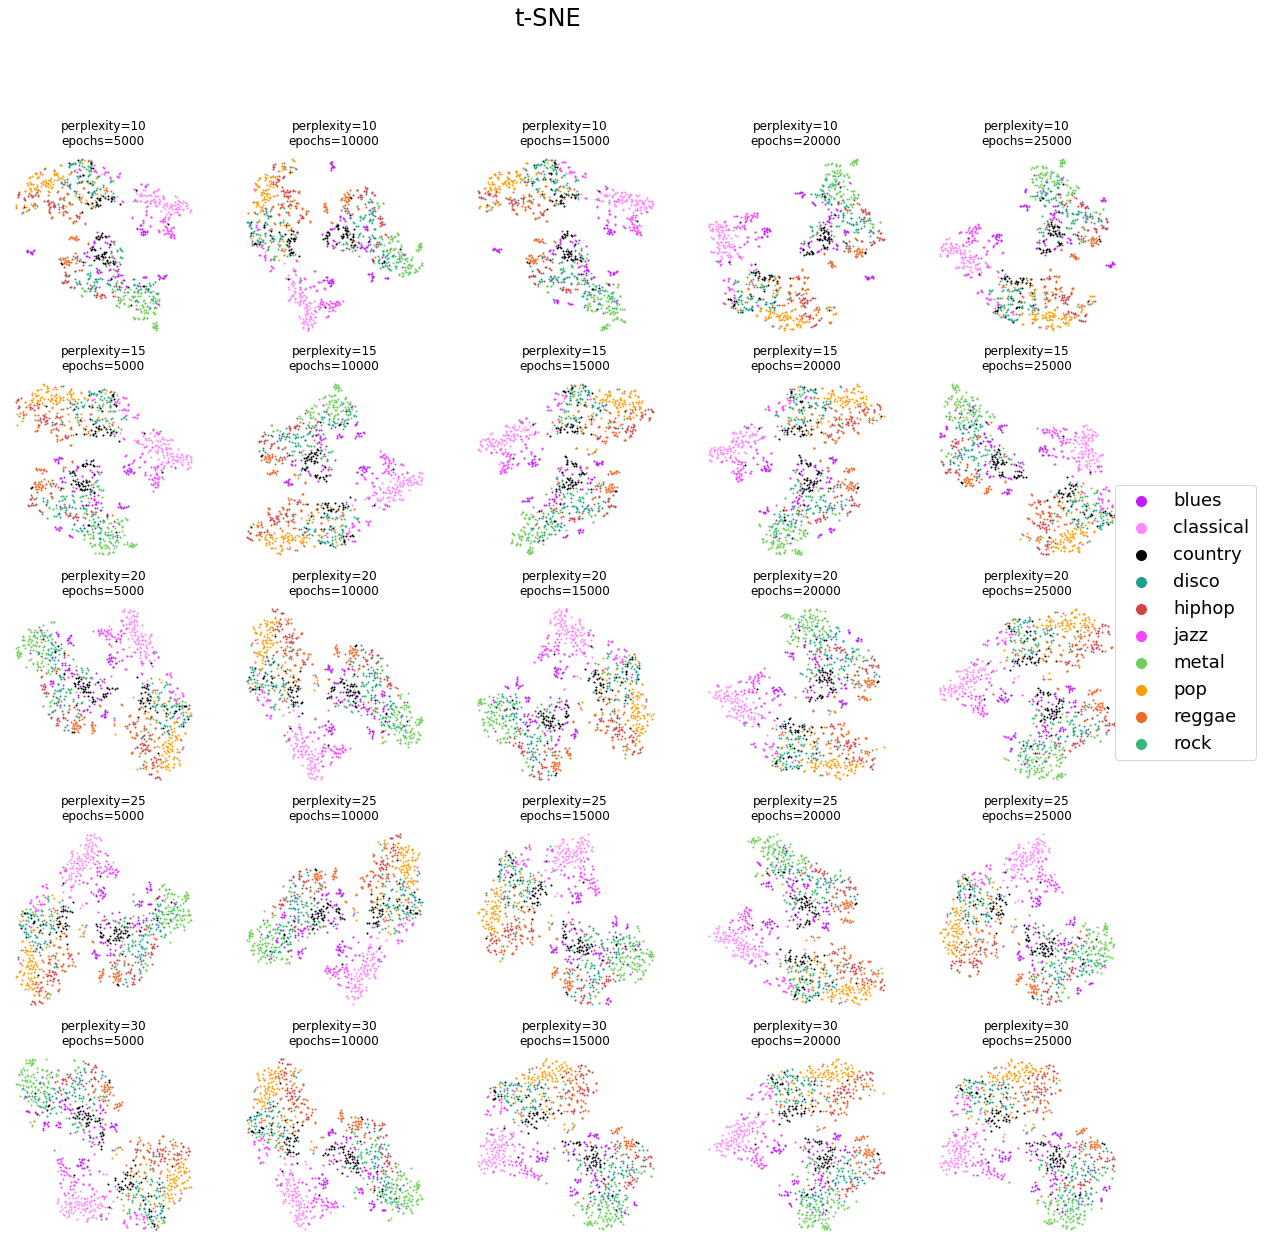

In [7]:
plot_components(tsne_embeddings, len(perplexities), len(iterations), "perplexity={}\nepochs={}","t-SNE")

In [8]:
umap_embeddings = dict()
neighbors = list(range(10,31,5))
distances = [0.01, 0.02, 0.03, 0.04, 0.05]
for neighbor, distance in tqdm(list(itertools.product(neighbors,distances))):#for a prettier progress bar
    umap_embedding = get_umap_embeddings(features,
                                         neighbor=neighbor,
                                         distance=distance)
    umap_embeddings[f"{neighbor}_{distance}"]= umap_embedding

  0%|          | 0/25 [00:00<?, ?it/s]

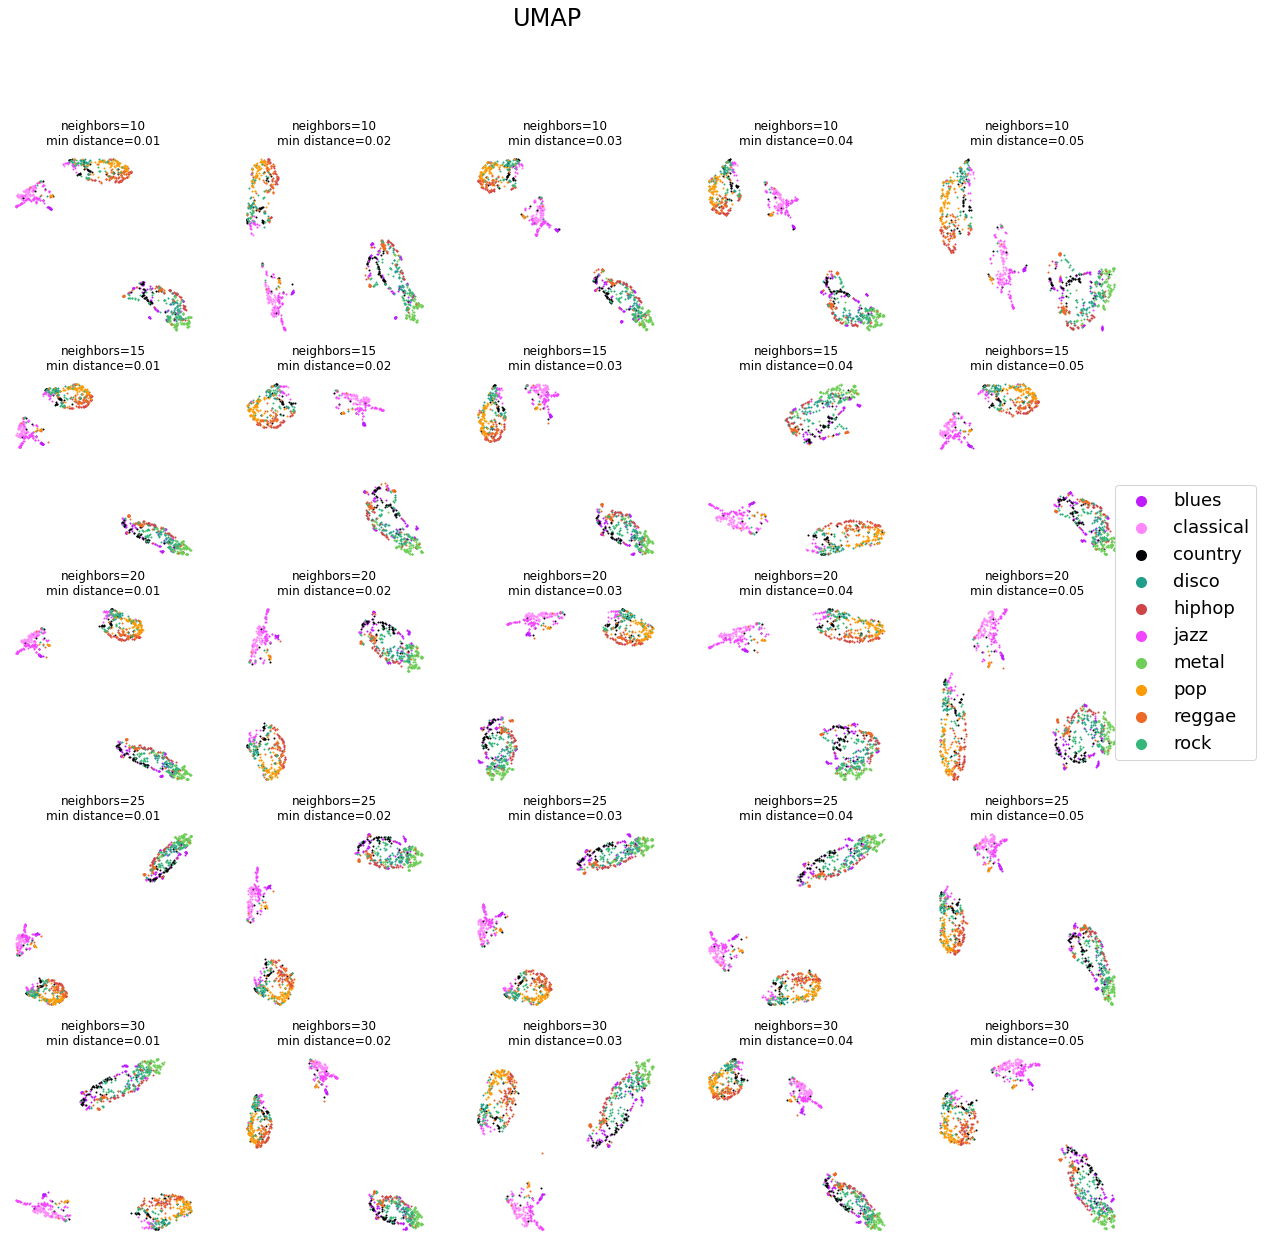

In [9]:
plot_components(umap_embeddings, len(neighbors), len(distances), "neighbors={}\nmin distance={}","UMAP")

In [10]:
tsne_embedding = get_tsne_embeddings(features,
                                     n_components=3,
                                     perplexity=30,
                                     iteration=20000)
df_tsne = pd.DataFrame(tsne_embedding)
df_tsne.columns = ['pc1','pc2','pc3']
df_tsne['genre'] = df.iloc[:,-1]

In [11]:
data = []
for g in df_tsne.genre.unique():
    trace = go.Scatter3d(
    x=df_tsne[df_tsne.genre==g].pc1.values,
    y=df_tsne[df_tsne.genre==g].pc2.values,
    z=df_tsne[df_tsne.genre==g].pc3.values,
    mode='markers',
    name=g,
    marker=dict(
            size=3,
            color=color_scheme[g],                
            opacity=0.9,
        )
    )
    data.append(trace)
fig = go.Figure(data=data)

fig.update_layout(title=f'TSNE', autosize=False,
                      width=600, height=600,
                      margin=dict(l=50, r=50, b=50, t=50),
                      scene=dict(xaxis=dict(title='pc1'), yaxis=dict(title='pc2'), zaxis=dict(title='pc3'))
                     )
fig.show()

In [12]:
umap_embedding = get_umap_embeddings(features,
                                     n_components=3,
                                     neighbor=20,
                                     distance=0.05)
df_umap = pd.DataFrame(umap_embedding)
df_umap.columns = ['pc1','pc2','pc3']
df_umap['genre'] = df.iloc[:,-1]
df_umap['color'] = df_umap.genre.apply(lambda x: color_scheme[x])

In [13]:
data = []
for g in df_umap.genre.unique():
    trace = go.Scatter3d(
    x=df_umap[df_umap.genre==g].pc1.values,
    y=df_umap[df_umap.genre==g].pc2.values,
    z=df_umap[df_umap.genre==g].pc3.values,
    mode='markers',
    name=g,
    marker=dict(
            size=3,
            color=color_scheme[g],                
            opacity=0.9,
        )
    )
    data.append(trace)
fig = go.Figure(data=data)

# tight layout
fig.update_layout(title=f'UMAP (Unsupervised)', autosize=False,
                      width=600, height=600,
                      margin=dict(l=50, r=50, b=50, t=50),
                      scene=dict(xaxis=dict(title='pc1'), yaxis=dict(title='pc2'), zaxis=dict(title='pc3'))
                     )
fig.show()